# Plot the training curves of the track fitting models

A Track fitting model aims to fit the positions of the trajectory points of a track, givent its hits. In this notebook we plot the training curve of a given hit tagging model

### Define parameters

In [7]:
primary_tracks_only = True # Do we use the dataset with primary tracks only or with all tracks?
predict_directions = True # Do we also predict directions or only positions?
use_sparse_cnn=False # Is the model a Sparse CNN MinkUNet or a Transformer?
finetuned=False # Was the model finetuned?
intermediate=False # Is the model an intermediate finetuning step?

use_weighted_loss=False

### Define paths

In [8]:
model_root_path=f"../../models_weights/"
train_set_path="/scratch4/maubin/data/pgun_train"
scaler_file_path="../../sfgnets/datasets/scalers/scaler_trackfit.p"
prediction_root_path=f"/scratch4/maubin/results_best_models/"

### Define model parameters

In [9]:
# j=22 # id of the model (useful when testing many models)
j=f"{'p' if primary_tracks_only else 'a'}{'PD' if predict_directions else 'P'}" # best models are indexed by their data configuration ("pP","pPD","aP","aPD")
targets=[0,1] if  predict_directions else [0] # indexes of the targets to be used: 0 is the position, 1 the direction
inputs=[0] # indexes of the inputs to be used: 0 is the charge, 1 is the hit tag

model_path=f"{model_root_path}trackfit_model_{'sparse_cnn_' if use_sparse_cnn else ''}{j}{'_finetuned' if finetuned else ''}{'_intermediate' if intermediate else ''}.torch"
training_dict_path=f'{prediction_root_path}trackfit_training_dict_{"sparse_cnn_" if use_sparse_cnn else ""}{j}{"_finetuned" if finetuned else ""}{"_intermediate" if intermediate else ""}.torch'

In [10]:
import os
import sys
import pickle as pk
import torch.nn as nn
import tqdm
import numpy as np
import torch
import importlib
import matplotlib.pyplot as plt


# Manually specify the GPUs to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

torch.multiprocessing.set_sharing_strategy('file_system')


from sfgnets import track_fitting_net
importlib.reload(track_fitting_net)

<module 'sfgnets.track_fitting_net' from '/home/maubin/SFG/modules/sfgnets/track_fitting_net/__init__.py'>

In [11]:
training_dict=torch.load(training_dict_path)

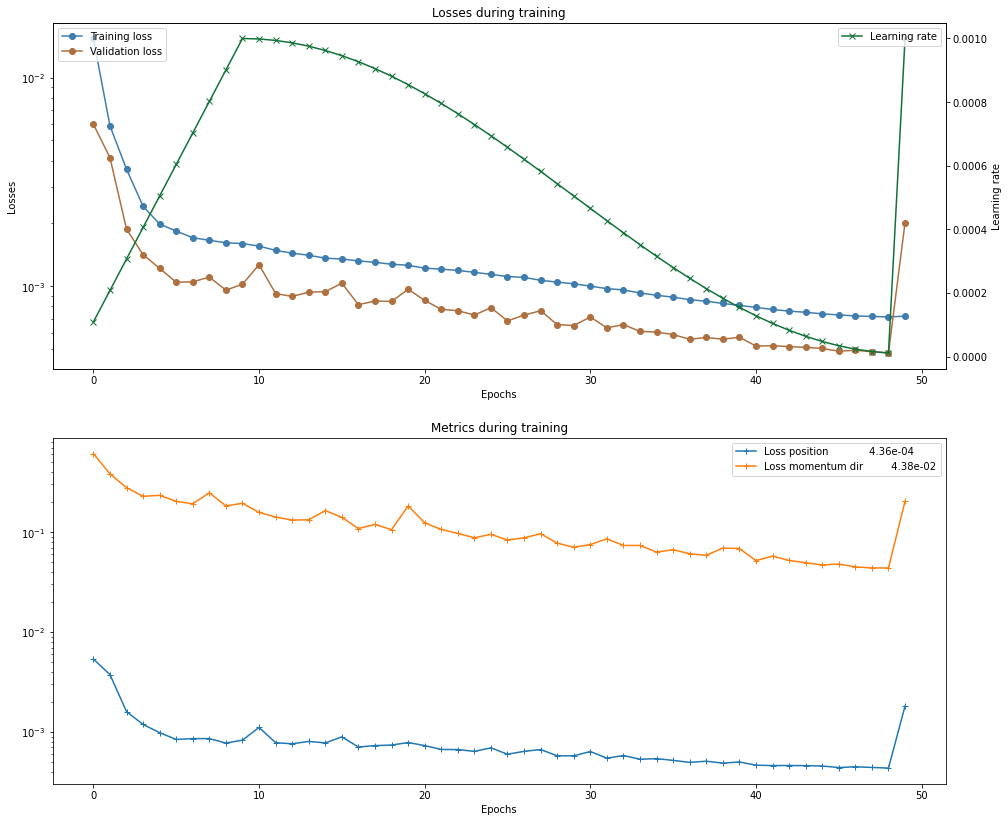

In [13]:
color_list = ["#3f7dae","#ae703f",'#117238', '#4e6206', '#6e4d00','#823312','#851433']
loss_components=["Loss position", "Loss momentum dir", "Loss momentum norm", "Loss momentum reg"]
# loss_components=["Loss position", "Loss momentum dir"]
if targets is None:
    targets=[k for k in range(len(loss_components))]

fig,axes=plt.subplots(2,1,figsize=(16,14), facecolor="white")

axes[0].plot(training_dict["training_loss"],label="Training loss", color=color_list[0], marker="o")
axes[0].plot(training_dict["validation_loss"],label="Validation loss", color=color_list[1], marker="o")
ax_lr=axes[0].twinx()
ax_lr.plot(training_dict["learning_rate"],label="Learning rate", color=color_list[2], marker="x")
# ax_lr.set_yscale('log')
ax_lr.set_ylabel('Learning rate')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Losses')
axes[0].set_yscale('log')
axes[0].set_title('Losses during training')
axes[0].legend(loc='upper left')
ax_lr.legend(loc='upper right')


for k,label in enumerate(list(np.array(loss_components)[targets])):
    _loss=training_dict["validation_loss_composition"][:,k]*(training_dict["loss_weights"][k] if use_weighted_loss else 1.)
    axes[1].plot(_loss,label=f"{f'{label:<25} {_loss.min():.2e}'}", marker="+")
axes[1].set_xlabel('Epochs')
axes[1].set_title(f'Metrics during training{" (weighted)" if use_weighted_loss else ""}')
axes[1].set_yscale('log')
# axes[1].legend()
axes[1].legend(loc="upper right")

# k=np.argmax(training_dict["f1_score"])

# txt_string=f"F1 score:            {training_dict['f1_score'][k]*100:.2f}%\n"
# txt_string+=f"Precision:           {training_dict['precision'][k]*100:.2f}%\n"
# txt_string+=f"Recall:                {training_dict['recall'][k]*100:.2f}%\n"
# txt_string+=f"Epoch:                {k}"

# y_pos= min(np.min(training_dict['precision']),np.min(training_dict['recall']),np.min(training_dict['f1_score']))+0.1*(max(np.max(training_dict['precision']),np.max(training_dict['recall']),np.max(training_dict['f1_score']))- min(np.min(training_dict['precision']),np.min(training_dict['recall']),np.min(training_dict['f1_score'])))
# axes[1].text(len(training_dict['precision'])*0.8,y_pos, txt_string, multialignment='left', bbox=dict(facecolor='#e0dade', alpha=0.5))

# fig.suptitle(f"Training results for ")

# print(f"Maximum F1 score: \t{training_dict['f1_score'][k]*100:.2f}%")
# print(f"Precision: \t\t{training_dict['precision'][k]*100:.2f}%")
# print(f"Recall: \t\t{training_dict['recall'][k]*100:.2f}%")
fig.show()